# NLP Disaster Tweets Kaggle Mini-Project

## Import libraries & data

In [15]:
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import classification_report


In [2]:
os.listdir()

['glove.6B',
 'glove.6B.zip',
 'nlp-getting-started',
 'nlp-getting-started.zip',
 'nlp_disaster_tweets.ipynb']

In [3]:
# unzip file nlp-getting-started.zip
with zipfile.ZipFile('nlp-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('nlp-getting-started')


In [4]:
# unzip 'glove.6B.zip'
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('glove.6B')

Data Exploration    

In [5]:
data_path = "nlp-getting-started"
test = pd.read_csv(data_path + "/test.csv")
train = pd.read_csv(data_path + "/train.csv")

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Step 1: Brief description of the problem and data 
* The purpose of this project is to use natural language processing and deep learning model to determine whether or not a tweet is related to a real disaster or not. 
* The training data has 7613 rows and 5 columns
    * "text" column contains the tweet
    * "target" is binary 1/0 tag for if it's about a real disaster or not
* The test data has 3263 rows and 4 columns

In [8]:
# get training data and test data shapes
print(train.shape, test.shape)

(7613, 5) (3263, 4)


In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Step 2: Exploratory Data Analysis - Inpsect, Visualize and Clean the Data

### Visualization

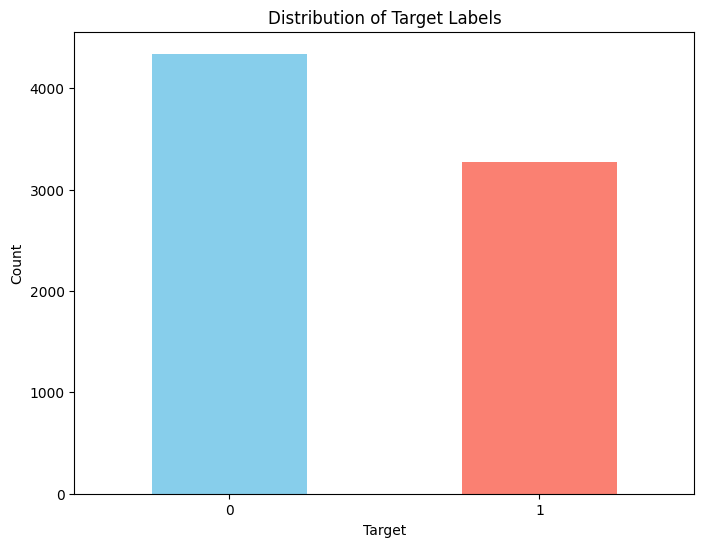

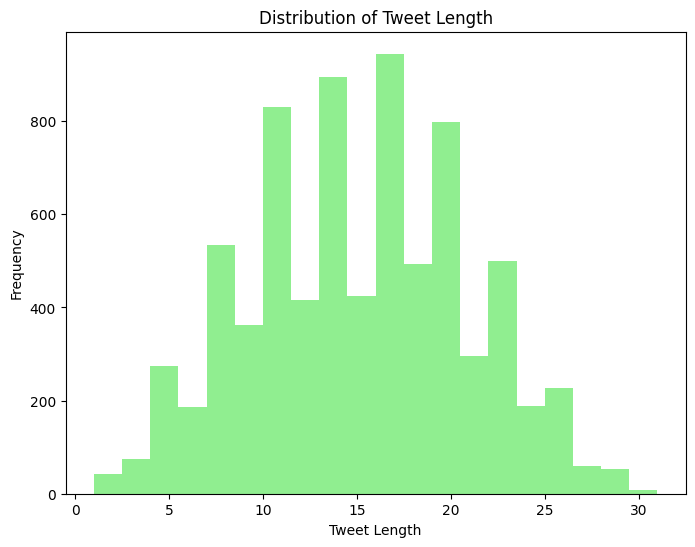

In [11]:
# Visualize the distribution of target labels
plt.figure(figsize=(8, 6))
train['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Labels')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Analyze the length of the tweets
train['tweet_length'] = train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
plt.hist(train['tweet_length'], bins=20, color='lightgreen')
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


### Cleaning the data

In [12]:
# Handle missing values
train.dropna(inplace=True)

# Text preprocessing

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters, URLs, and usernames
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'https?://\S+', ' ', text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to the tweet column
train['clean_text'] = train['text'].apply(preprocess_text)


## Step 3: Model Architecture
For the purposes of this project, I will use a sequential neural network model, specifically BVidriectional LSTM (Long Short-Term Memory) architecture. 

1. Squential Data: Tweets are like any sentences are sequences of words and thus the meaning of each word depens on the context/nuance of surrounding words. Therefore, bidirectional LSTMs would work well for processing sequential data
2. Long-Term Dependencies: LSTMs address the vanishing gradient issue and are capable of capturing long-term dependencies in the text data. 
3. For word embedding, I will use Glove embedding. - https://nlp.stanford.edu/projects/glove/

### Building the model

In [13]:
# split 
train_data, test_data, train_labels, test_labels = train_test_split(
    train, train['target'], test_size=0.2, random_state=42
)

texts = train_data['clean_text'].values  # pre-processed text data
labels = train_data['target'].values  # labels

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Find the maximum length for padding
max_seq_length = max(len(seq) for seq in sequences)
word_index = tokenizer.word_index

# Pad sequences to ensure uniform input size
data = pad_sequences(sequences, maxlen=max_seq_length)

# Load GloVe embeddings
embeddings_index = {}
glove_path = 'glove.6B/glove.6B.100d.txt'  
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


### Train Model

In [17]:
# Initialize the Sequential model correctly
model = Sequential()

# Add the Embedding layer as previously defined
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

# Continue with the Bidirectional LSTM and Dense layers as intended
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))  # Correct output layer for binary classification

# Compile the model correctly
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ensure `labels` is correctly shaped (e.g., a 1D array for binary classification)
# It might be useful to print the shape of `data` and `labels` to verify
print(data.shape, labels.shape)

# Proceed to train the model, assuming `data` and `labels` are correctly formatted
model.fit(data, labels, epochs=10, batch_size=32, validation_split=0.2)

(4064, 33) (4064,)
Epoch 1/10


102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6941 - loss: 0.5855 - val_accuracy: 0.8007 - val_loss: 0.4574
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8192 - loss: 0.4095 - val_accuracy: 0.8032 - val_loss: 0.4303
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8731 - loss: 0.3083 - val_accuracy: 0.8093 - val_loss: 0.4593
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9101 - loss: 0.2284 - val_accuracy: 0.8032 - val_loss: 0.4572
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9528 - loss: 0.1450 - val_accuracy: 0.7897 - val_loss: 0.5760
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9745 - loss: 0.0893 - val_accuracy: 0.7811 - val_loss: 0.6581
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9841 - loss: 0.0493 - val_accuracy: 0.7159 - val_loss: 0.9795
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9901 - loss: 0.0326 - val_accuracy: 0.789

## Step 4 Results and Analysis
**Model Accuracy:**

* The training accuracy is very high, close to 100%, from the first epoch and remains consistent throughout the training.
* The validation accuracy starts lower and exhibits significant variability, fluctuating around 75-80%.
* There is a considerable gap between training and validation accuracy, which typically indicates overfitting: the model is learning to perform very well on the training data but is not generalizing as effectively to unseen validation data.

**Model Loss:**

* The training loss is very low, close to zero, which is consistent with the high training accuracy.
* The validation loss starts higher than the training loss and also shows variability, although it appears to increase slightly over epochs.
* Similar to the accuracy graph, the loss graph shows a divergence between training and validation, further suggesting overfitting.

**Summary and Analysis:**
* Overfitting: The model's performance on the training set is nearly perfect, which is rarely achievable in practice with unseen data. This overfitting is corroborated by the lower and more volatile performance on the validation set.

* Generalization Gap: The substantial difference between training and validation metrics suggests that the model may have memorized aspects of the training data that do not generalize well to the validation data.

**Improvements to Consider:**

* Data Augmentation: Since the model is overfitting, you can increase the diversity of the training data through data augmentation techniques tailored for NLP, such as synonym replacement or sentence shuffling.
* Regularization: Introduce dropout or L1/L2 regularization in the LSTM or Dense layers to reduce overfitting.
* Model Simplification: Try using a simpler model or fewer units in your LSTM layer to see if it reduces overfitting.
* Early Stopping: Implement early stopping to halt training when the validation accuracy stops improving.
* Hyperparameter Tuning: Experiment with different learning rates or other hyperparameters that might lead to better generalization.

In [18]:
loss, accuracy = model.evaluate(data, labels, verbose=0)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')


Validation Loss: 0.1839
Validation Accuracy: 0.9486


### Confusion Matrix 
* The model shows a relatively high number of True Positives and True Negatives, indicating good predictive power.
* False Positives and False Negatives are relatively low, which suggests a balanced performance in terms of Type I and Type II errors.
* Given the high numbers of True Positives and True Negatives, the model's accuracy is likely to be high.

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


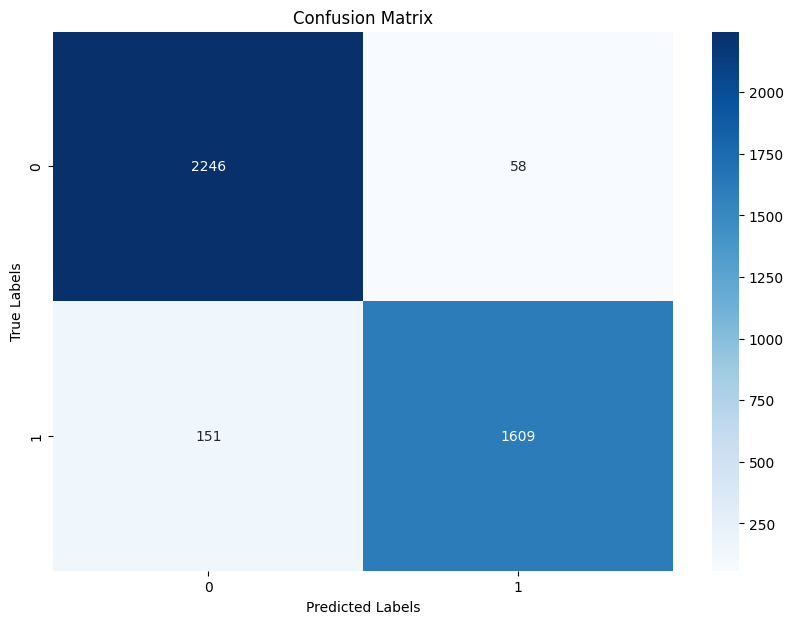

In [19]:
predictions = (model.predict(data) > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [20]:
# Convert test_data to TensorFlow Tensor
test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])
test_data_tensor = pad_sequences(test_sequences, maxlen=max_seq_length)

# Convert test_data_tensor to TensorFlow Tensor
test_data_tensor = tf.convert_to_tensor(test_data_tensor)

# Predict probabilities for test data
test_predictions_prob = model.predict(test_data_tensor)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Ensure test_labels has the same length as test_predictions
test_labels = test_data['target'][:len(test_predictions)]

# Evaluate the metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

# Print the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy: 0.7982
Test Precision: 0.8164
Test Recall: 0.6835
Test F1 Score: 0.7441


## Step 5 
**Improvements to Consider:**

* Data Augmentation: Since the model is overfitting, you can increase the diversity of the training data through data augmentation techniques tailored for NLP, such as synonym replacement or sentence shuffling.
* Regularization: Introduce dropout or L1/L2 regularization in the LSTM or Dense layers to reduce overfitting.
* Model Simplification: Try using a simpler model or fewer units in your LSTM layer to see if it reduces overfitting.
* Early Stopping: Implement early stopping to halt training when the validation accuracy stops improving.
* Hyperparameter Tuning: Experiment with different learning rates or other hyperparameters that might lead to better generalization.

## For Kaggle 
use test

In [21]:
# Clean test data
test['clean_text'] = test['text'].apply(preprocess_text)
test_text = test["clean_text"]

# Tokenize and pad the text data
test_sequences = tokenizer.texts_to_sequences(test_text)
test_data_tensor = pad_sequences(test_sequences, maxlen=max_seq_length)

# Convert test_data_tensor to TensorFlow Tensor
test_data_tensor = tf.convert_to_tensor(test_data_tensor)

# Predict probabilities for test data
test_predictions_prob = model.predict(test_data_tensor)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Create a DataFrame with id and predicted target columns
output_df = pd.DataFrame({'id': test['id'], 'target': test_predictions.flatten()})


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:
output_df.shape

(3263, 2)

In [24]:
output_df.to_csv('submission.csv', index=False)